In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/superstore/Sample - Superstore.xls


In [41]:
from fbprophet import Prophet
df=pd.read_excel("../input/superstore/Sample - Superstore.xls")
print(df.head())

   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10

In [42]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
import pandas as pd
import statsmodels.api as sm
import matplotlib
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [43]:
technology=df.loc[df['Category']=='Technology']
technology['Order Date'].min(),technology['Order Date'].max()
cols=['Row ID','Order ID','Ship Date','Ship Mode','Customer ID','Customer Name','Segment','Country','City','State','Postal Code','Region','Product ID','Category','Sub-Category','Product Name','Quantity','Discount','Profit']
technology.drop(cols,axis=1,inplace=True)
technology=technology.sort_values('Order Date')
technology.isnull().sum()
technology=technology.groupby('Order Date')['Sales'].sum().reset_index()
technology=technology.set_index('Order Date')
technology.index


DatetimeIndex(['2014-01-06', '2014-01-09', '2014-01-13', '2014-01-15',
               '2014-01-16', '2014-01-20', '2014-01-26', '2014-02-01',
               '2014-02-02', '2014-02-06',
               ...
               '2017-12-18', '2017-12-21', '2017-12-22', '2017-12-23',
               '2017-12-24', '2017-12-25', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=824, freq=None)

In [44]:
k=technology['Sales'].resample('MS').mean()
k['2017':]

Order Date
2017-01-01    1195.218071
2017-02-01     430.501714
2017-03-01    1392.859250
2017-04-01     825.559133
2017-05-01     678.329400
2017-06-01     853.055000
2017-07-01    1054.996636
2017-08-01     978.842333
2017-09-01    1077.704120
2017-10-01    1493.439227
2017-11-01    1996.750920
2017-12-01     955.865652
Freq: MS, Name: Sales, dtype: float64

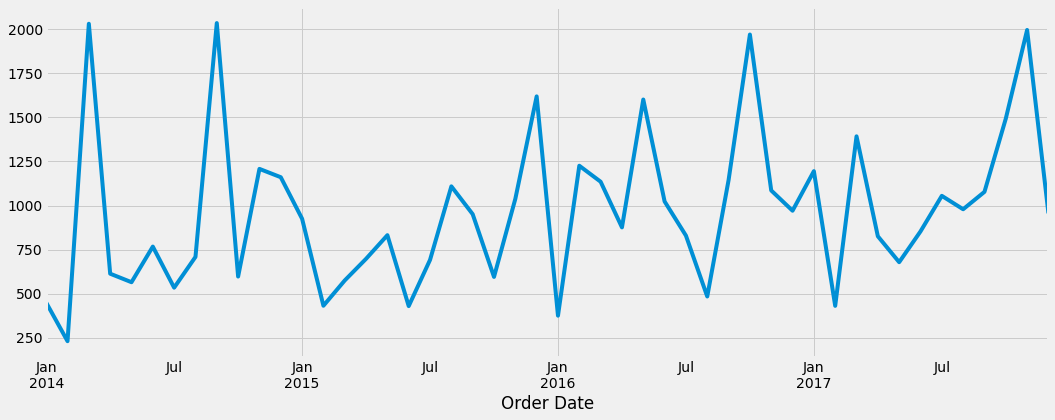

In [45]:
k.plot(figsize=(16,6))
plt.show()

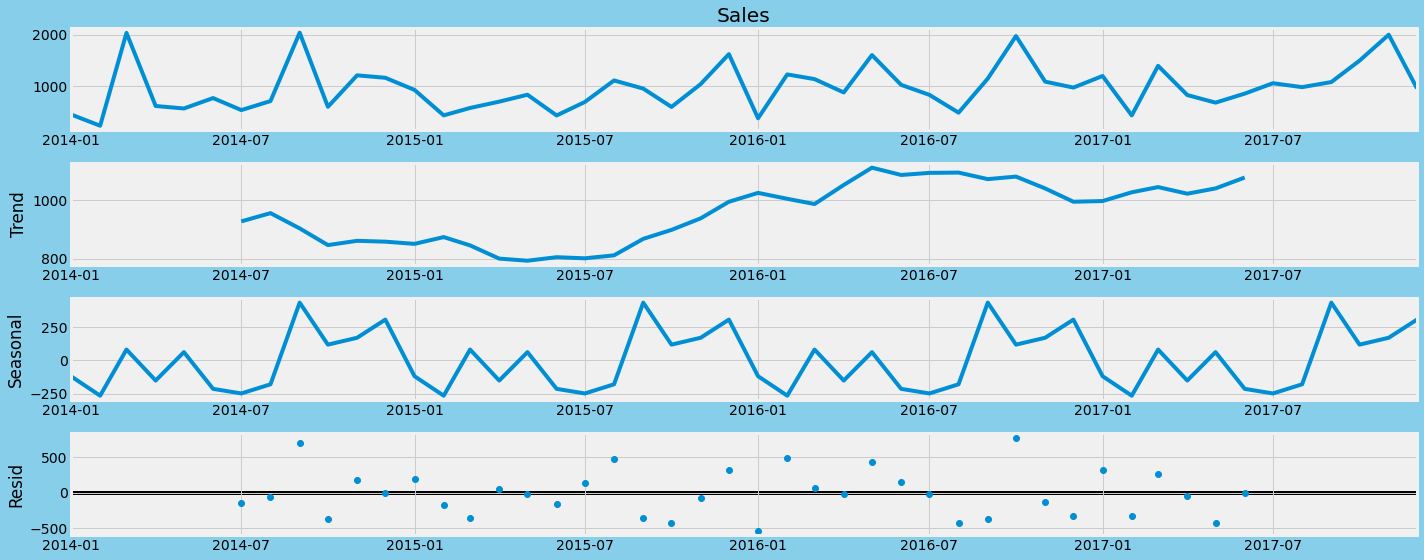

In [46]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8
rcParams['figure.facecolor']='skyblue'
decomposition = sm.tsa.seasonal_decompose(k, model='additive')
fig = decomposition.plot()
plt.show()

In [47]:

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [48]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(k,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            
            continue
mod.fit(disp=0)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39015D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   8.390D+00
  F =   8.3901477871423005     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:807.4541875656608
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-3.994E+01  -gs= 9.758E-01 BFGS update SKIPPED

At iterate    5    f=  2.35107D+01    |proj g|=  3.27778D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7    117      3     3     0   2.665D+04   2.173D+01
  F =   21.728336651631320     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2089.9203185566066
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.87414D+00    |proj g|=  4.84267D-04

           * * *

Tit  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.77326D+00    |proj g|=  5.21765D-03

At iterate   15    f=  5.76958D+00    |proj g|=  5.92590D-02

At iterate   20    f=  5.75550D+00    |proj g|=  1.85016D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     24      1     0     0   7.875D-07   5.755D+00
  F =   5.7554761393426643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:556.5257093768957
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.43523D+01    |proj g|=  4.79179D-01
  ys=-2.221E+02  -gs= 7.522E-01 BFGS update SKIPPED
  ys=-1.546E+02  -gs= 9.930E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9    103      2     2     0   1.908D+05   2.006D+01
  F =   20.058439278437898     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1931.6101707300381
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.76408D+00    |proj g|=  2.91868D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.10253D+01    |proj g|=  1.81293D-02
  ys=-5.835E+01  -gs= 8.698E-01 BFGS update SKIPPED

At iterate   10    f=  2.87951D+01    |proj g|=  2.79617D+02
  ys=-3.408E+01  -gs= 9.738E-01 BFGS update SKIPPED
  ys=-5.213E+01  -gs= 9.815E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     96      2     3     0   1.513D+04   2.488D+01
  F =   24.877211934584096     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2394.2123457200732
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85004D+00    |proj g|=  4.39770D-02

At iterate    5    f=  5.84854D+00    |proj g|=  3.19568D-04

At iterate   10    f=  5.84851D+00    |proj g|=  6.07604D-03

At iterate   15    f=  5.84747D+00    |proj g|=  3.83084D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     21      1     0     0   2.542D-06   5.847D+00
  F =   5.8474583435474150     

CONVERGENCE: 

 This problem is unconstrained.



At iterate   15    f=  5.75628D+00    |proj g|=  4.06597D-02

At iterate   20    f=  5.74349D+00    |proj g|=  1.45175D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   2.802D-06   5.743D+00
  F =   5.7431522985081349     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:557.3426206567809
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19700D+00    |proj g|=  9.81448D-02

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  7.92633D+00    |proj g|=  3.89084D-02

At iterate   25    f=  7.91585D+00    |proj g|=  1.00970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     29      1     0     0   4.429D-06   7.916D+00
  F =   7.9158509348042232     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:765.9216897412055
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04115D+01    |proj g|=  1.08569D-01

At iterate    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17    106      2     1     0   8.085D+04   2.083D+01
  F =   20.832877401047053     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2007.9562305005172
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75805D+00    |proj g|=  6.41970D-02

At iterate    5    f=  5.75385D+00    |proj g|=  2.69136D-04

At iterate   10    f=  5.75374D+00    |proj g|=  7.43893D-03

At iterate   

 This problem is unconstrained.



At iterate   20    f=  5.74029D+00    |proj g|=  1.42882D-02

At iterate   25    f=  5.74010D+00    |proj g|=  6.93667D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   6.937D-07   5.740D+00
  F =   5.7400986753478938     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:559.0494728333978
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73201D+00    |proj g|=  3.23739D-05

           * *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.12745D+01    |proj g|=  2.30623D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     86      3     1     0   2.306D+04   2.127D+01
  F =   21.274544474406632     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2046.3562695430367
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02368D+00    |proj g|=  3.48232D-04

           * * *

Tit   = total number of iterations
Tnf   = total number o


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:578.3279350725917
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.00356D+00    |proj g|=  2.99722D-01

At iterate    5    f=  5.89387D+00    |proj g|=  4.04919D-04

At iterate   10    f=  5.89366D+00    |proj g|=  1.44984D-02

At iterate   15    f=  5.87795D+00    |proj g|=  1.07590D-01

At iterate   20    f=  5.85788D+00    |proj g|=  1.53271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     24      1     0     0   3.977D-

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.76735D+00    |proj g|=  4.96578D-03

At iterate   10    f=  7.76311D+00    |proj g|=  7.10827D-02

At iterate   15    f=  7.72863D+00    |proj g|=  1.12434D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     21      1     0     0   7.653D-06   7.728D+00
  F =   7.7284687689273701     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:745.9330018170275
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  2.20984D+01    |proj g|=  6.09113D-02

At iterate   20    f=  2.20984D+01    |proj g|=  1.68673D+00

At iterate   25    f=  2.20983D+01    |proj g|=  1.97146D+01

At iterate   30    f=  2.20973D+01    |proj g|=  2.19788D+02

At iterate   35    f=  2.20859D+01    |proj g|=  2.44248D+03

At iterate   40    f=  2.19226D+01    |proj g|=  2.89251D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     43    149      3     2     0   1.653D+05   2.061D+01
  F =   20.610943664886513     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1984.6505918291052
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91635D+00    |proj g|=  6.81982D-02

At iterate    5    f=  5.91033D+00    |proj g|=  1.38150D-05

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.



At iterate   10    f=  5.89045D+00    |proj g|=  1.68633D-02

At iterate   15    f=  5.85610D+00    |proj g|=  1.55977D-02

At iterate   20    f=  5.85564D+00    |proj g|=  9.59411D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     27      1     0     0   9.805D-07   5.856D+00
  F =   5.8556421103550251     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:568.1416425940824
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.91452D+01    |proj g|=  1.45348D-01
  ys=-1.370E+02  -gs= 9.183E-01 BFGS update SKIPPED
  ys=-5.377E+01  -gs= 9.595E-01 BFGS update SKIPPED

At iterate   10    f=  2.08728D+01    |proj g|=  1.19260D+05
  ys=-5.132E+00  -gs= 9.450E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11    115      2     3     0   1.193D+05   2.087D+01
  F =   20.872784593129929     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2009.7873209404731
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75038D+00    |proj g|=  1.35070D-01

At iterate    5    f=  5.74541D+00    |proj g|=  1.57747D-04

At iterate   10    f=  5.74540D+00    |proj g|=  6.82459D-03

At iterate   

 This problem is unconstrained.



At iterate    5    f=  5.65379D+00    |proj g|=  4.47590D-04

At iterate   10    f=  5.65376D+00    |proj g|=  8.30147D-03

At iterate   15    f=  5.65105D+00    |proj g|=  8.14423D-02

At iterate   20    f=  5.61203D+00    |proj g|=  1.73252D-01

At iterate   25    f=  5.59457D+00    |proj g|=  2.24215D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     29      1     0     0   8.744D-06   5.595D+00
  F =   5.5945660061414983     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:543.0783365895838
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.97205D+01    |proj g|=  3.21765D-03

At iterate   10    f=  3.96987D+01    |proj g|=  2.29303D-02
  ys=-3.150E+01  -gs= 9.505E-01 BFGS update SKIPPED

At iterate   15    f=  2.32136D+01    |proj g|=  4.60408D+04
  ys=-8.703E+01  -gs= 9.682E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     97      2     2     0   4.604D+04   2.321D+01
  F =   23.213594367453769     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2236.505059275562
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66733D+00    |proj g|=  5.30516D-02

At iterate    5    f=  5.66371D+00    |proj g|=  3.89243D-04

At iterate   10    f=  5.66369D+00    |proj g|=  5.27328D-03

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  5.65018D+00    |proj g|=  7.12985D-04

At iterate   15    f=  5.64995D+00    |proj g|=  1.89392D-02

At iterate   20    f=  5.63198D+00    |proj g|=  1.61947D-01

At iterate   25    f=  5.59197D+00    |proj g|=  1.47113D-02

At iterate   30    f=  5.59131D+00    |proj g|=  1.41682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     35      1     0     0   2.050D-06   5.591D+00
  F =   5.5913090928733595     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:544.7656729158425
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.301E+01  -gs= 9.600E-01 BFGS update SKIPPED

At iterate   10    f=  2.11723D+01    |proj g|=  1.19795D+05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     99      2     1     0   1.198D+05   2.117D+01
  F =   21.172275502498980     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2038.5384482399022
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85041D+00    |proj g|=  7.76604D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.97147D+01    |proj g|=  1.60956D-03

At iterate   10    f=  3.97039D+01    |proj g|=  6.45380D-02

At iterate   15    f=  2.26564D+01    |proj g|=  4.80765D+04
  ys=-3.702E+00  -gs= 8.097E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17    103      2     1     0   2.679D+05   1.943D+01
  F =   19.428902320342875     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1873.174622752916
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.76599D+00    |proj g|=  2.37809D-02

At iterate    5    f=  5.76530D+00    |proj g|=  7.02379D-04

At iterate   10    f=  5.76499D+00    |proj g|=  1.37438D-02

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  5.74962D+00    |proj g|=  6.07393D-02

At iterate   25    f=  5.74407D+00    |proj g|=  9.01101D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   9.011D-06   5.744D+00
  F =   5.7440665739247789     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:559.4303910967787
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96158D+01    |proj g|=  2.31983D+02

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02082D+01    |proj g|=  3.61093D-02

At iterate    5    f=  4.01694D+01    |proj g|=  2.01559D-02
  ys=-2.523E+02  -gs= 1.008E+00 BFGS update SKIPPED

At iterate   10    f=  2.72223D+01    |proj g|=  2.82264D+03
  ys=-3.949E+01  -gs= 9.762E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13    111      2     2     0   1.010D+05   2.235D+01
  F =   22.345234231732565     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2153.1424862463264
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85673D+00    |proj g|=  2.44242D-02

At iterate    5    f=  5.84836D+00    |proj g|=  2.29451D-02

At iterate   10    f=  5.84743D+00    |proj g|=  1.96628D-04

At iterate   

 This problem is unconstrained.



At iterate    5    f=  5.76051D+00    |proj g|=  2.54388D-02

At iterate   10    f=  5.75641D+00    |proj g|=  2.99106D-04

At iterate   15    f=  5.75639D+00    |proj g|=  2.58519D-03

At iterate   20    f=  5.75522D+00    |proj g|=  2.62856D-02

At iterate   25    f=  5.74237D+00    |proj g|=  1.73624D-02

At iterate   30    f=  5.74207D+00    |proj g|=  1.47214D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     37      1     0     0   4.334D-06   5.742D+00
  F =   5.7420722131439073     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:559.2389324618

 This problem is unconstrained.



At iterate   15    f=  7.70101D+00    |proj g|=  1.02695D-01

At iterate   20    f=  7.60835D+00    |proj g|=  8.44397D-03

At iterate   25    f=  7.58167D+00    |proj g|=  4.84795D-03

At iterate   30    f=  7.57980D+00    |proj g|=  1.32726D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     36      1     0     0   7.306D-05   7.580D+00
  F =   7.5798042890699611     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:735.6612117507162
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  3.94051D+01    |proj g|=  3.35695D-03

At iterate   10    f=  3.69152D+01    |proj g|=  5.59125D-01
  ys=-2.047E+01  -gs= 7.715E-01 BFGS update SKIPPED
  ys=-3.973E+01  -gs= 8.793E-01 BFGS update SKIPPED
  ys=-1.429E+02  -gs= 9.905E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-3.559E+01  -gs= 9.734E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14    101      3     4     0   1.198D+04   2.462D+01
  F =   24.617830633462049     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2373.3117408123567



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.76182D+00    |proj g|=  3.36742D-02

At iterate    5    f=  5.75303D+00    |proj g|=  1.12710D-02

At iterate   10    f=  5.75284D+00    |proj g|=  2.60929D-04

At iterate   15    f=  5.75273D+00    |proj g|=  8.06787D-03

At iterate   20    f=  5.74838D+00    |proj g|=  6.94585D-02

At iterate   25    f=  5.74425D+00    |proj g|=  1.36987D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  5.75468D+00    |proj g|=  5.83598D-02

At iterate   10    f=  5.75056D+00    |proj g|=  2.04576D-03

At iterate   15    f=  5.75054D+00    |proj g|=  2.84972D-04

At iterate   20    f=  5.75050D+00    |proj g|=  4.73912D-03

At iterate   25    f=  5.74715D+00    |proj g|=  2.38213D-02

At iterate   30    f=  5.74050D+00    |proj g|=  2.95510D-02

At iterate   35    f=  5.73945D+00    |proj g|=  2.54703D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     44      1     0     0   2.766D-06   5.739D+00
  F =   5.7394507254529747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-6.759E+01  -gs= 9.650E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5     87      2     2     0   5.845D+04   2.227D+01
  F =   22.273895032885317     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2144.2939231569903
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90662D+00    |proj g|=  5.06826D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.082D-05   5.907D+00
  F =   5.9065863733982260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:571.0322918462297
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =    

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-5.076E+01  -gs= 5.378E-01 BFGS update SKIPPED
  ys=-1.998E+02  -gs= 9.745E-01 BFGS update SKIPPED
  ys=-1.076E+02  -gs= 9.670E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     97      2     3     0   2.247D+05   2.291D+01
  F =   22.913404444460326     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2207.6868266681913
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.82247D+00    |proj g|=  4.55329D-02

At iterate    5    f=  5.81950D+00    |proj g|=  6.61036D-04

At iterate   10    f=  5.81906D+00    |proj g|=  1.41087D-02

At iterate   

 This problem is unconstrained.



At iterate   15    f=  5.80476D+00    |proj g|=  4.63863D-03

At iterate   20    f=  5.79919D+00    |proj g|=  4.10443D-02

At iterate   25    f=  5.76919D+00    |proj g|=  3.58886D-02

At iterate   30    f=  5.76695D+00    |proj g|=  4.57920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     37      1     0     0   1.007D-05   5.767D+00
  F =   5.7669517196587217     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:561.6273650872373
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.50379D+01    |proj g|=  8.16535D-01
  ys=-1.277E+02  -gs= 9.727E-01 BFGS update SKIPPED
  ys=-6.759E+01  -gs= 9.637E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     98      2     2     0   1.216D+05   2.129D+01
  F =   21.293018789268491     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2052.129803769775
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75148D+00    |proj g|=  1.46902D-01

At iterate    5    f=  5.74106D+00    |proj g|=  9.84274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.



At iterate    5    f=  5.64868D+00    |proj g|=  4.64570D-04

At iterate   10    f=  5.64866D+00    |proj g|=  4.04390D-03

At iterate   15    f=  5.64592D+00    |proj g|=  4.05519D-02

At iterate   20    f=  5.59404D+00    |proj g|=  9.91630D-02

At iterate   25    f=  5.58384D+00    |proj g|=  1.60637D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   4.785D-06   5.584D+00
  F =   5.5838295193709380     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:544.0476338596101
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.97192D+01    |proj g|=  2.32345D-03

At iterate   10    f=  3.96650D+01    |proj g|=  1.13799D-01
  ys=-2.012E+01  -gs= 6.851E-01 BFGS update SKIPPED

At iterate   15    f=  2.40122D+01    |proj g|=  2.38646D+04
  ys=-4.040E+01  -gs= 9.782E-01 BFGS update SKIPPED
  ys=-8.733E+00  -gs= 8.488E-01 BFGS update SKIPPED
  ys=-4.711E-02  -gs= 2.890E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18    131      2     4     0   3.135D+05   1.958D+01
  F =   19.577655919261030     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1889.4549682490588
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66664D+00    |proj g|=  8.67247D-02

At iterate    5    f=  5.65409D+00    |proj g|=  1.06266D-03

At iterate   10    f=  5.65408D+00    |proj g|=  5.48103D-03

At iterate   

 This problem is unconstrained.



At iterate   20    f=  5.61887D+00    |proj g|=  1.09751D-01

At iterate   25    f=  5.61137D+00    |proj g|=  1.80359D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   3.905D-06   5.611D+00
  F =   5.6113738233478587     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:546.6918870413945
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75148D+00    |proj g|=  3.16998D-01


 This problem is unconstrained.



At iterate    5    f=  5.64380D+00    |proj g|=  5.24083D-03

At iterate   10    f=  5.64360D+00    |proj g|=  4.73741D-04

At iterate   15    f=  5.64343D+00    |proj g|=  1.05698D-02

At iterate   20    f=  5.62365D+00    |proj g|=  1.26693D-01

At iterate   25    f=  5.58271D+00    |proj g|=  2.86824D-02

At iterate   30    f=  5.57852D+00    |proj g|=  3.21986D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     37      1     0     0   5.337D-06   5.578D+00
  F =   5.5784711606635744     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:545.5332314237

In [49]:
mod = sm.tsa.statespace.SARIMAX(k,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
mod.fit(disp=0)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75148D+00    |proj g|=  3.16998D-01

At iterate    5    f=  5.64380D+00    |proj g|=  5.24083D-03

At iterate   10    f=  5.64360D+00    |proj g|=  4.73741D-04


 This problem is unconstrained.



At iterate   15    f=  5.64343D+00    |proj g|=  1.05698D-02

At iterate   20    f=  5.62365D+00    |proj g|=  1.26693D-01

At iterate   25    f=  5.58271D+00    |proj g|=  2.86824D-02

At iterate   30    f=  5.57852D+00    |proj g|=  3.21986D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     37      1     0     0   5.337D-06   5.578D+00
  F =   5.5784711606635744     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.

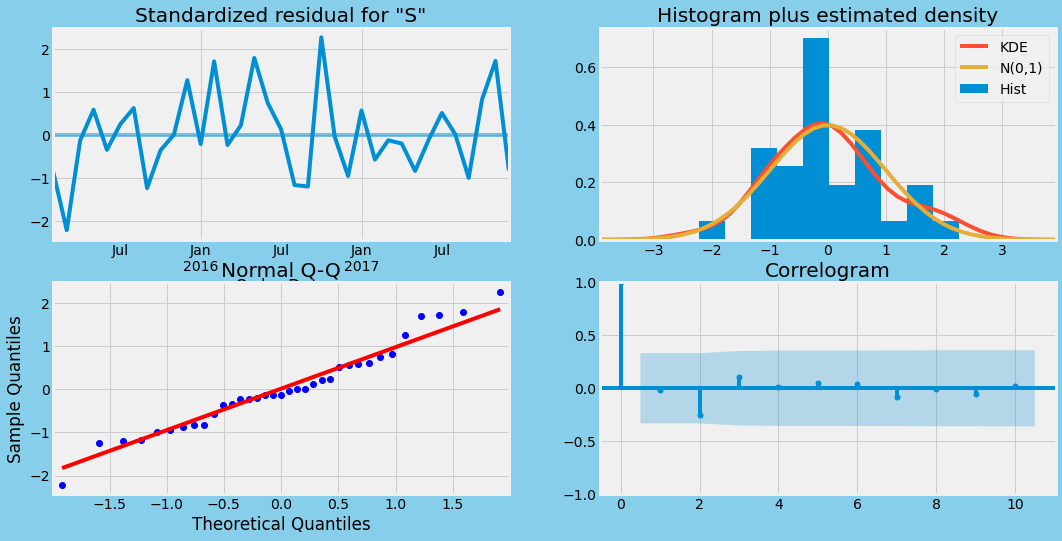

In [50]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

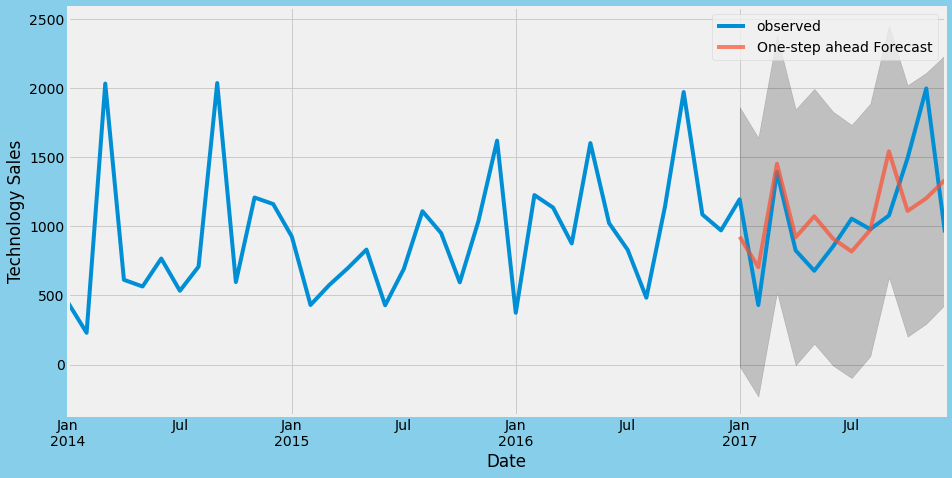

In [51]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = k['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Technology Sales')
plt.legend()
plt.show()

In [52]:
k_forecasted = pred.predicted_mean
k_truth = k['2017-01-01':]
mse = ((k_forecasted - k_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 126006.7


In [53]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 354.97


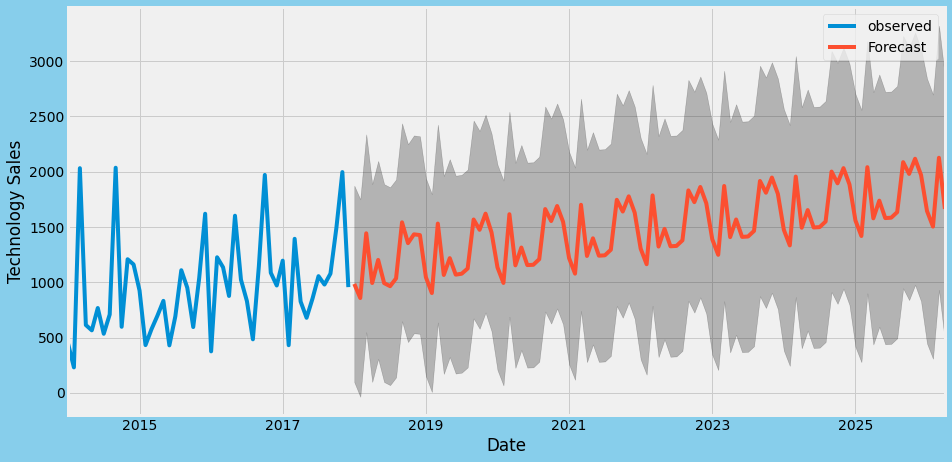

In [54]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = k.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Technology Sales')
plt.legend()
plt.show()

In [55]:
technology = df.loc[df['Category'] == 'Technology']
office = df.loc[df['Category'] == 'Office Supplies']
technology.shape, office.shape

((1847, 21), (6026, 21))

In [56]:
technology = df.loc[df['Category'] == 'Technology']
furniture = df.loc[df['Category'] == 'Furniture']
technology.shape, furniture.shape

((1847, 21), (2121, 21))

In [57]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
technology.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture.drop(cols, axis=1, inplace=True)
technology = technology.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture=furniture.sort_values('Order Date')
technology = technology.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture=furniture.groupby('Order Date')['Sales'].sum().reset_index()
technology = technology.set_index('Order Date')
office = office.set_index('Order Date')
furniture=furniture.set_index('Order Date')
k_technology = technology['Sales'].resample('MS').mean()
k_office = office['Sales'].resample('MS').mean()
k_furniture=furniture['Sales'].resample('MS').mean()
technology = pd.DataFrame({'Order Date':k_technology.index, 'Sales':k_technology.values})
office = pd.DataFrame({'Order Date': k_office.index, 'Sales': k_office.values})
furniture= pd.DataFrame({'Order Date': k_furniture.index, 'Sales': k_furniture.values})
store = technology.merge(office, how='inner', on='Order Date')
store1=technology.merge(furniture, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'technology_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,technology_sales,office_sales
0,2014-01-01,449.041429,285.357647
1,2014-02-01,229.787143,63.042588
2,2014-03-01,2031.948375,391.176318
3,2014-04-01,613.028933,464.794750
4,2014-05-01,564.698588,324.346545


In [58]:
store1.rename(columns={'Sales_x': 'technology_sales', 'Sales_y': 'furniture_sales'}, inplace=True)
store1.head()

,Order Date,technology_sales,furniture_sales
0,2014-01-01,449.041429,480.194231
1,2014-02-01,229.787143,367.931600
2,2014-03-01,2031.948375,857.291529
3,2014-04-01,613.028933,567.488357
4,2014-05-01,564.698588,432.049188


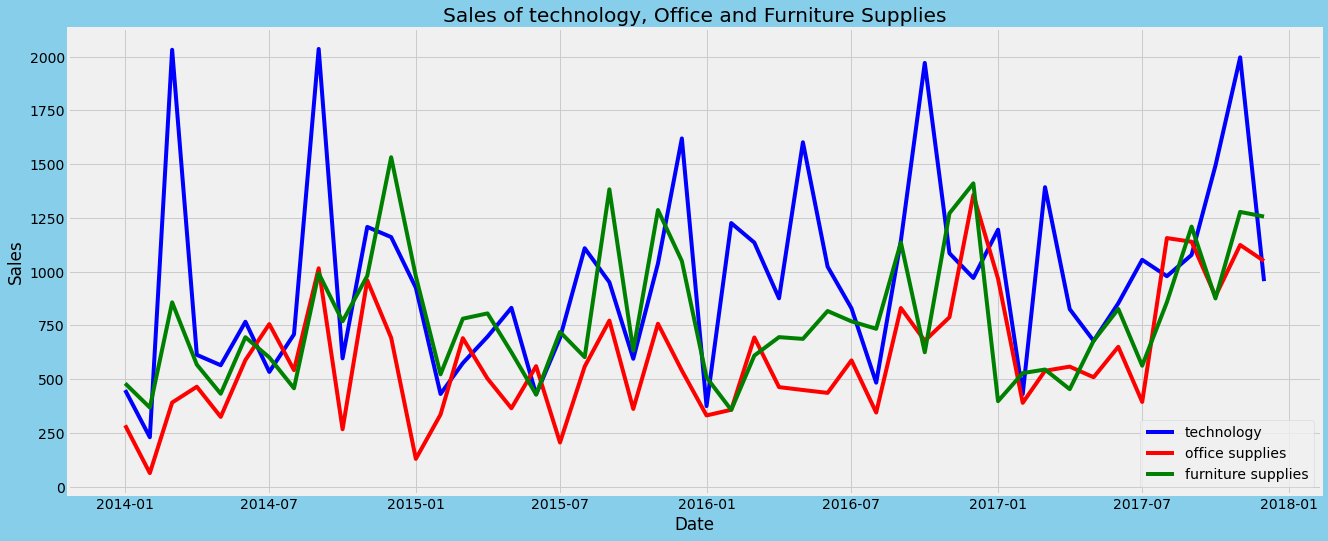

In [59]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['technology_sales'], 'b-', label = 'technology')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.plot(store1['Order Date'], store1['furniture_sales'], 'g-', label = 'furniture supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of technology, Office and Furniture Supplies')
plt.legend();

In [60]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['technology_sales'])[0])), 'Order Date']
print("Office supplies first time produced higher sales than technology is {}.".format(first_date.date()))

Office supplies first time produced higher sales than technology is 2014-07-01.


In [61]:
sec_date = store.loc[np.min(list(np.where(store['office_sales'] > store1['furniture_sales'])[0])), 'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(sec_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


In [62]:
th_date = store.loc[np.min(list(np.where(store1['furniture_sales'] > store['office_sales'])[0])), 'Order Date']
print("Furniture supplies first produced higher sales than furniture is {}.".format(th_date.date()))

Furniture supplies first produced higher sales than furniture is 2014-01-01.


In [63]:
#Prophet model implementation


Initial log joint probability = -59.7409
Iteration  1. Log joint probability =    36.0894. Improved by 95.8303.
Iteration  2. Log joint probability =    50.2517. Improved by 14.1624.
Iteration  3. Log joint probability =    65.8778. Improved by 15.626.
Iteration  4. Log joint probability =    70.0617. Improved by 4.18397.
Iteration  5. Log joint probability =    70.6171. Improved by 0.555431.
Iteration  6. Log joint probability =    70.6503. Improved by 0.0331714.
Iteration  7. Log joint probability =    71.1781. Improved by 0.527814.
Iteration  8. Log joint probability =    71.2536. Improved by 0.0754692.
Iteration  9. Log joint probability =    71.2586. Improved by 0.00494821.
Iteration 10. Log joint probability =    71.2967. Improved by 0.0381678.
Iteration 11. Log joint probability =    71.3033. Improved by 0.00654426.
Iteration 12. Log joint probability =    71.3325. Improved by 0.0291994.
Iteration 13. Log joint probability =    71.3409. Improved by 0.00846069.
Iteration 14. Log

<Figure size 1296x432 with 0 Axes>

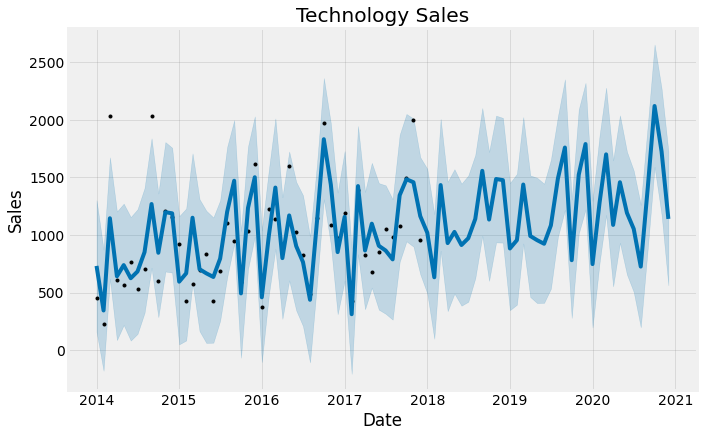

In [64]:
technology = technology.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
technology_model = Prophet(interval_width=0.95)
technology_model.fit(technology)
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)
technology_forecast = technology_model.make_future_dataframe(periods=36, freq='MS')
technology_forecast = technology_model.predict(technology_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)
plt.figure(figsize=(18, 6))
technology_model.plot(technology_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Technology Sales');

<Figure size 1296x432 with 0 Axes>

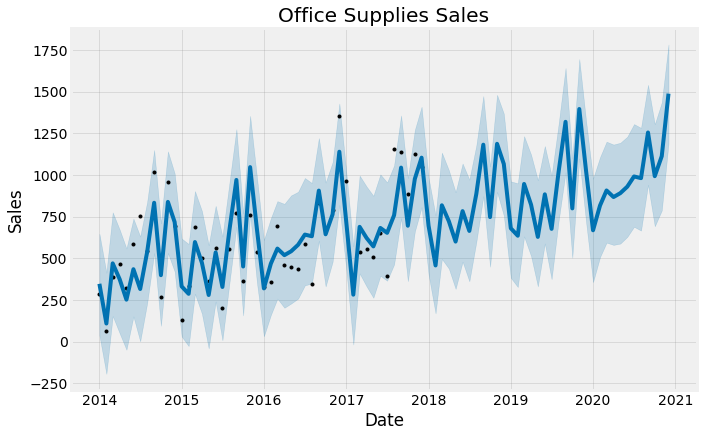

In [65]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');


In [66]:
technology_names = ['technology_%s' % column for column in technology_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_technology_forecast = technology_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_technology_forecast.columns = technology_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_technology_forecast, merge_office_forecast, how = 'inner', left_on = 'technology_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'technology_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,technology_trend,technology_yhat_lower,technology_yhat_upper,technology_trend_lower,technology_trend_upper,technology_additive_terms,technology_additive_terms_lower,technology_additive_terms_upper,technology_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,952.355848,158.447947,1302.734475,952.355848,952.355848,-220.575922,-220.575922,-220.575922,-220.575922,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,958.476983,-179.118915,873.545308,958.476983,958.476983,-613.862112,-613.862112,-613.862112,-613.862112,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,964.005750,619.793399,1674.978241,964.005750,964.005750,181.810553,181.810553,181.810553,181.810553,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,970.126885,87.522535,1204.550321,970.126885,970.126885,-328.523260,-328.523260,-328.523260,-328.523260,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,976.050565,218.376878,1272.652334,976.050565,976.050565,-237.352937,-237.352937,-237.352937,-237.352937,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


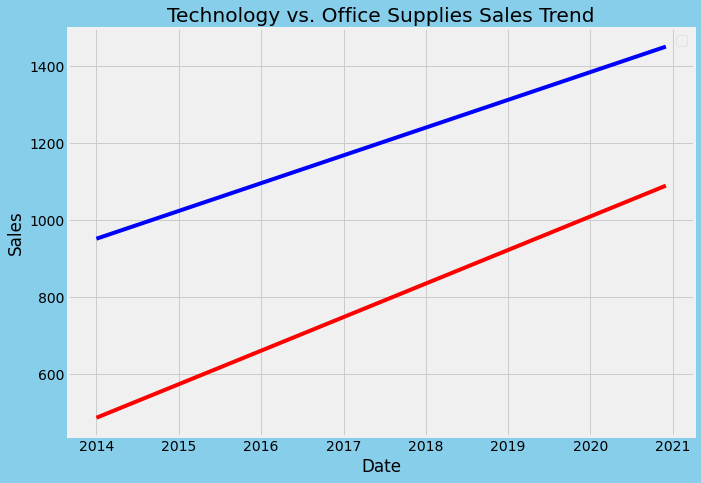

In [67]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['technology_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Technology vs. Office Supplies Sales Trend');

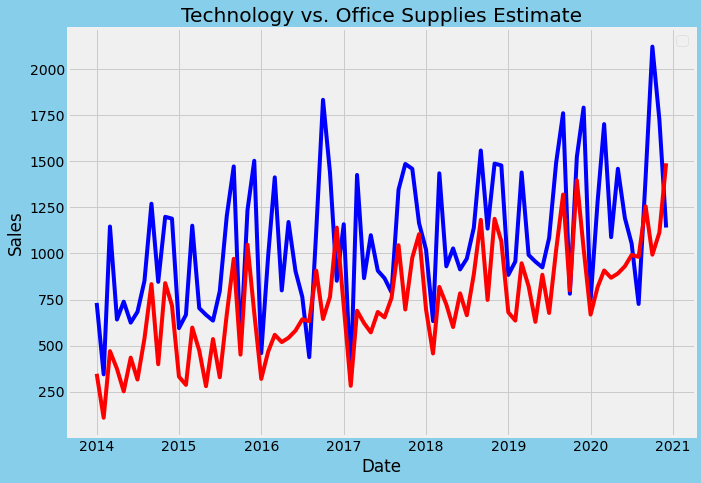

In [68]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['technology_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Technology vs. Office Supplies Estimate');

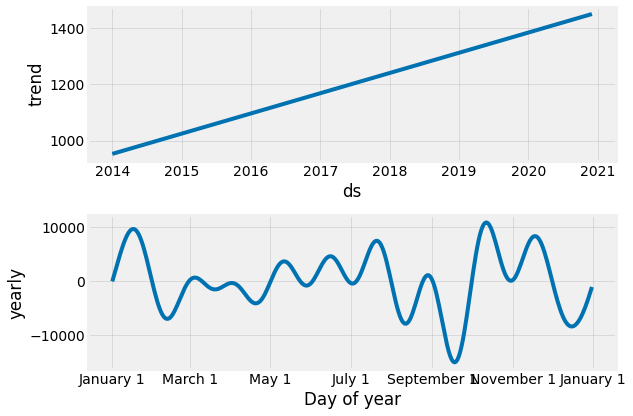

In [69]:
technology_model.plot_components(technology_forecast);

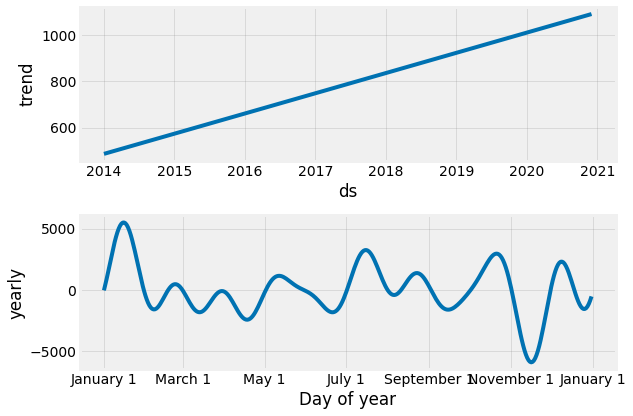

In [70]:
office_model.plot_components(office_forecast);


Initial log joint probability = -59.4782
Iteration  1. Log joint probability =    32.1963. Improved by 91.6745.
Iteration  2. Log joint probability =    66.4876. Improved by 34.2913.
Iteration  3. Log joint probability =    91.4725. Improved by 24.9849.
Iteration  4. Log joint probability =    97.1278. Improved by 5.65524.
Iteration  5. Log joint probability =     97.227. Improved by 0.099276.
Iteration  6. Log joint probability =    97.2722. Improved by 0.0451306.
Iteration  7. Log joint probability =    97.2786. Improved by 0.0064387.
Iteration  8. Log joint probability =    97.2875. Improved by 0.00892092.
Iteration  9. Log joint probability =    97.2913. Improved by 0.0037551.
Iteration 10. Log joint probability =    97.2951. Improved by 0.00385468.
Iteration 11. Log joint probability =    97.2963. Improved by 0.00112628.
Iteration 12. Log joint probability =    97.2966. Improved by 0.000305425.
Iteration 13. Log joint probability =    97.2991. Improved by 0.00250368.
Iteration 14

<Figure size 1296x432 with 0 Axes>

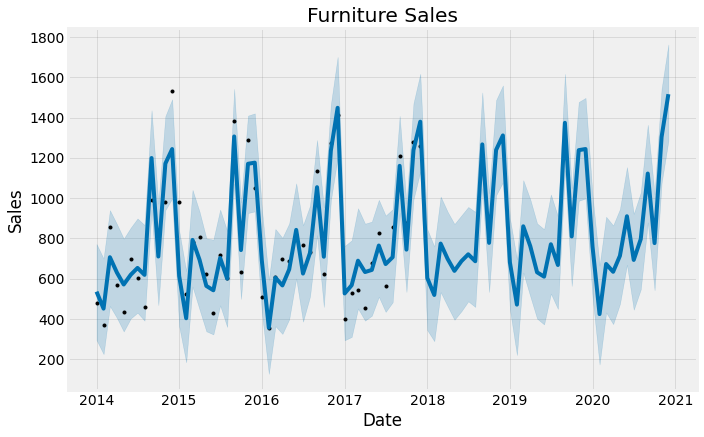

In [71]:
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)
technology = technology.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
technology_model = Prophet(interval_width=0.95)
technology_model.fit(office)
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
technology_forecast = technology_model.make_future_dataframe(periods=36, freq='MS')
technology_forecast = technology_model.predict(technology_forecast)
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

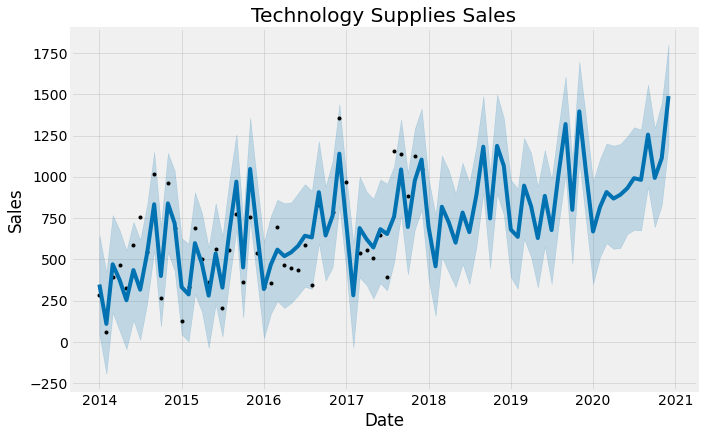

In [72]:
plt.figure(figsize=(18, 6))
technology_model.plot(technology_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Technology Supplies Sales');

In [73]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
technology_names = ['technology_%s' % column for column in technology_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_technology_forecast = technology_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_technology_forecast.columns = technology_names
forecast = pd.merge(merge_furniture_forecast, merge_technology_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'technology_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('technology_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,technology_additive_terms,technology_additive_terms_lower,technology_additive_terms_upper,technology_yearly,technology_yearly_lower,technology_yearly_upper,technology_multiplicative_terms,technology_multiplicative_terms_lower,technology_multiplicative_terms_upper,technology_yhat
0,2014-01-01,726.057713,294.770496,771.945132,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,225.455794,699.430197,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,464.031819,939.788944,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,405.022249,870.521034,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,337.860251,798.222928,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


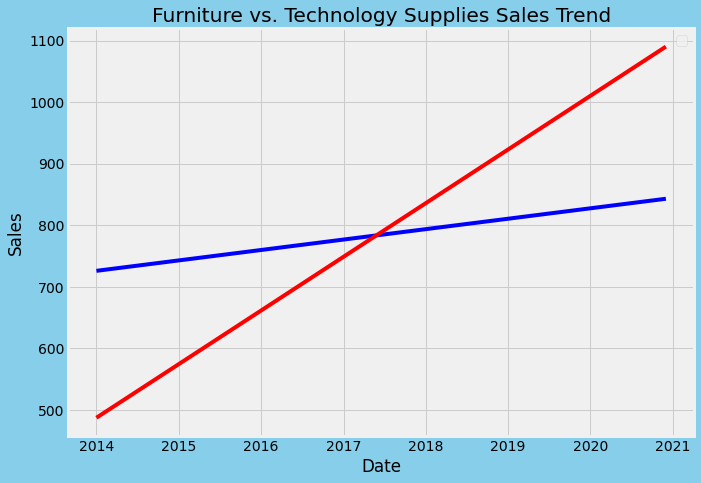

In [74]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['technology_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Technology Supplies Sales Trend');

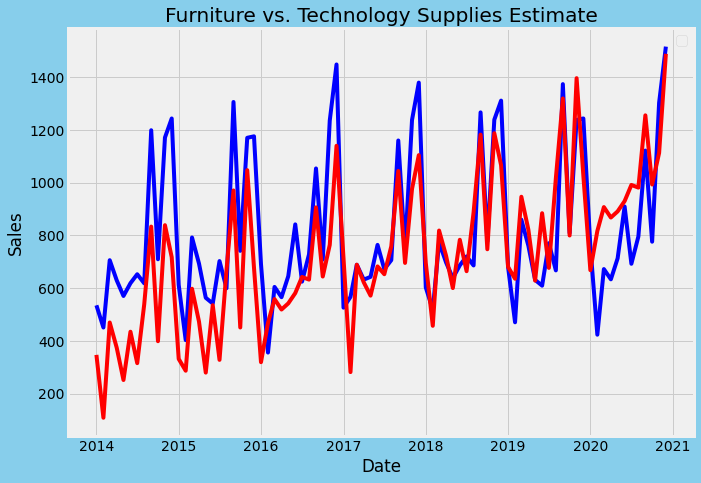

In [75]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['technology_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Technology Supplies Estimate');


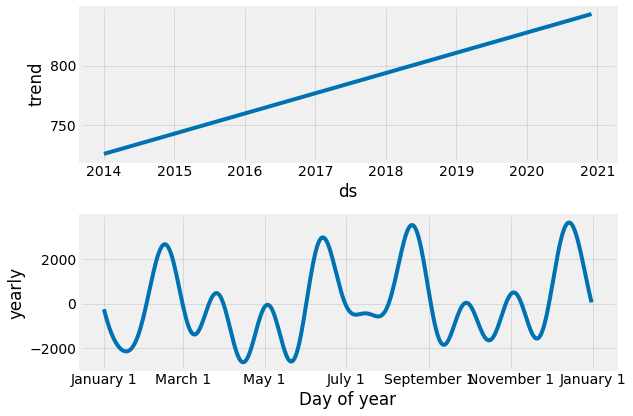

In [76]:
furniture_model.plot_components(furniture_forecast);

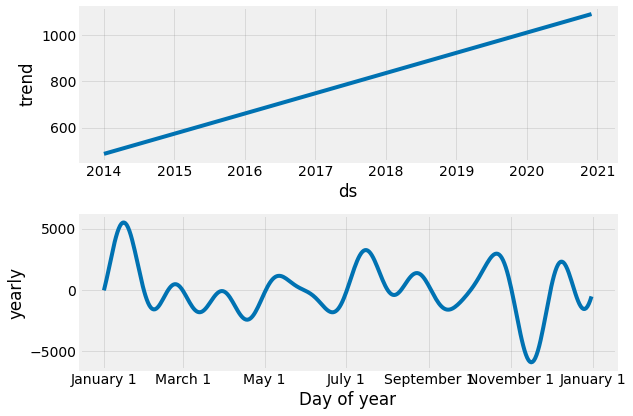

In [77]:
technology_model.plot_components(technology_forecast);